# **0. Importing Libraries**


In [1]:
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time

import torch
import torchvision
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **1. Data Loading**

**Paths**

In [2]:
example = '../input/flowers-recognition/flowers/flowers/daisy'
path = '/kaggle/input/flowers-recognition/flowers'

**Let's take a quick look at the data. I don't know about you, but the first thing I always want to do is look at what our data looks like :)**

Shape: (263, 320, 3)


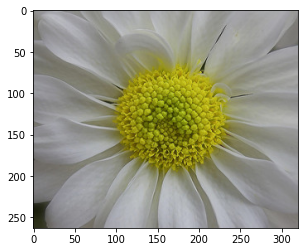

In [3]:
img = mpimg.imread('/kaggle/input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg')
print('Shape:', img.shape)
plt.imshow(img);

**From the image above, you can understand that they are not normalized (which is very expected), how strong the spread can be seen using the script below:**

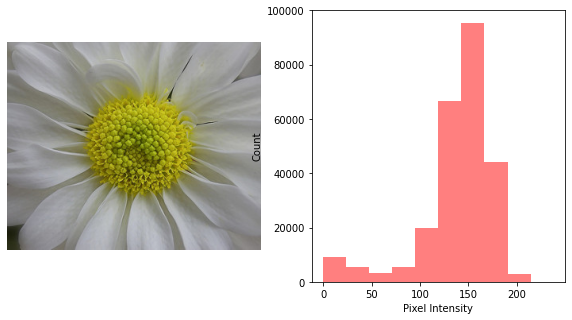

In [4]:
def plotHist(img):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.axis('off')
  histo = plt.subplot(1,2,2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Pixel Intensity')
  plt.hist(img.flatten(), bins=10, lw=0, alpha=0.5, color='r')

plotHist(img)

# **2. Data preparation**


**Let's write augmentation and normalization right away. Why are there four datasets?**

**(1)** The "original" dataset is the original dataset(wow), which we will split into two parts: test (20%) and training (80%).

**(2)** The dataset "dataset1" is a dataset with augmentation, which we will add to the training part of the original dataset to expand the data.

**(3)** The dataset "dataset2" is a dataset with augmentation, which we will add to the training part of the original dataset to expand the data.

**(4)** The dataset "dataset3" is a dataset with augmentation, which we will add to the training part of the original dataset to expand the data.


In [5]:
transformer = {
    'original': transform.Compose([
                                 transform.Resize((220, 220)),
                                 transform.ToTensor(), 
                                 transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), 
                                                     (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))
])  }

**pin_memory:** You know how sometimes your GPU memory shows that it’s full but you’re pretty sure that your model isn’t using that much? That overhead is called pinned memory. ie: this memory has been reserved as a type of “working allocation.”
When you enable pinned_memory in a DataLoader it “automatically puts the fetched data Tensors in pinned memory, and enables faster data transfer to CUDA-enabled GPUs”

**num_workers:** PyTorch allows loading data on multiple processes simultaneously. A good rule: ***num_worker = 4 * num_GPU***

In [6]:
bs = 32

data = ImageFolder(path, transform=transformer['original'])

#all_set = train_val + test
train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=43)


loaders = {
    'train': DataLoader(train, batch_size=bs, num_workers=4, pin_memory=True),
    'test': DataLoader(test, batch_size=bs, num_workers=4, pin_memory=True)
}

dataset_sizes = {
    'train': len(train),
    'test': len(test),
}

**We have already normalized the data, but at this stage I would like to dwell in more detail, because this is very important.**

In datasets, we have three-channel images, that is, we need to normalize for each channel separately (!!!). Because of the unnormalized data, problems may appear, for example, regularization during training can work to the detriment, but we do not want this at all. The task of normalization is to make the mean as close to zero as possible, and the standard deviation around 1. 

How each channel looks separately can be seen below:

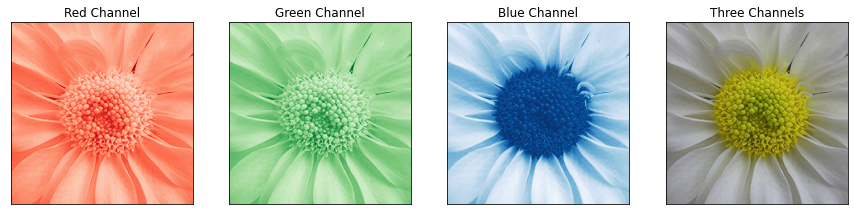

In [7]:
exampleset = ImageFolder(path, transform=transform.Compose([transform.ToTensor(),
                                                            transform.CenterCrop(255),]))

x, y = next(iter(DataLoader(exampleset)))

channels = ['Red', 'Green', 'Blue']
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for i, axs in enumerate(fig.axes[:3]):
    axs.imshow(x[0][i,:,:], cmap=cmaps[i])
    axs.set_title(f'{channels[i]} Channel')
    axs.set_xticks([])
    axs.set_yticks([])
    
ax[3].imshow(x[0].permute(1,2,0))
ax[3].set_title('Three Channels')
ax[3].set_xticks([])
ax[3].set_yticks([]);

**Now let's check how well we managed to normalize the data for each channel for the test, training and validation datasets:**

In [8]:
channels = 3

for channel in range(channels):
    for x in ['train', 'test']:
        #number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
        num_pxl = dataset_sizes[x]*220*220
    
        #we go through the butches and sum up the pixels of the objects, 
        #which then divide the sum by the number of all pixels to calculate the average
        total_sum = 0
        for batch in loaders[x]:
            layer = list(map(itemgetter(channel), batch[0]))
            layer = torch.stack(layer, dim=0)
            total_sum += layer.sum()
        mean = total_sum / num_pxl

        #we calculate the standard deviation using the formula that I indicated above
        sum_sqrt = 0
        for batch in loaders[x]: 
            layer = list(map(itemgetter(channel), batch[0]))
            sum_sqrt += ((torch.stack(layer, dim=0) - mean).pow(2)).sum()
        std = torch.sqrt(sum_sqrt / num_pxl)
        
        print(f'|channel:{channel+1}| {x} - mean: {mean}, std: {std}')

|channel:1| train - mean: 0.149931862950325, std: 0.9003611207008362
|channel:1| test - mean: 0.11246329545974731, std: 0.8949926495552063
|channel:2| train - mean: 0.18328283727169037, std: 0.9035656452178955
|channel:2| test - mean: 0.16574203968048096, std: 0.8847255706787109
|channel:3| train - mean: 0.1489660143852234, std: 0.9895642399787903
|channel:3| test - mean: 0.138411283493042, std: 0.9690633416175842


**Let's take a batch from the training dataset and see its mean and standard deviation:**

In [9]:
x, y = next(iter(loaders['train']))
x.mean(),  x.std()

(tensor(0.2457), tensor(0.9540))

**Let's take a look at the pixel distribution after normalization. Compared to the distribution at the beginning, the difference is large**

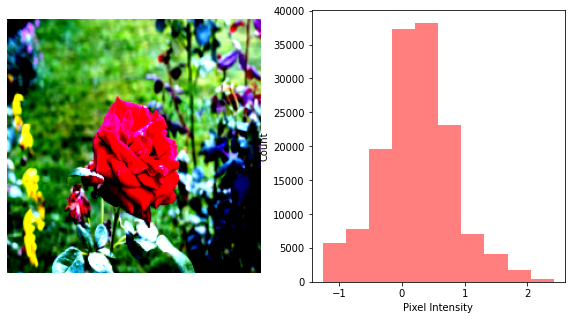

In [10]:
x, y = next(iter(loaders['train']))
img_norm = x[0].permute(1,2,0).numpy()
plotHist(img_norm)

**This is how we can look at our classes. There are only five of them, which is not much**

In [11]:
print('Classes:', data.classes)
print('Number of classes:', len(data.classes))

Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of classes: 5


**Let's check how imbalanced our data is. Since we are working with images, first we need to make a pandas table, and then render the table.**

In [12]:
dic = {}

for classes in data.classes:
  dic[classes] = [len([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)])]

samplesize = pd.DataFrame.from_dict(dic)

In [13]:
samplesize

,daisy,dandelion,rose,sunflower,tulip
0,764,1052,784,733,984


**The imbalance is small and we do not need to handle it in any way, since the ratio of the largest class to the smallest is 1.47, which is not much**

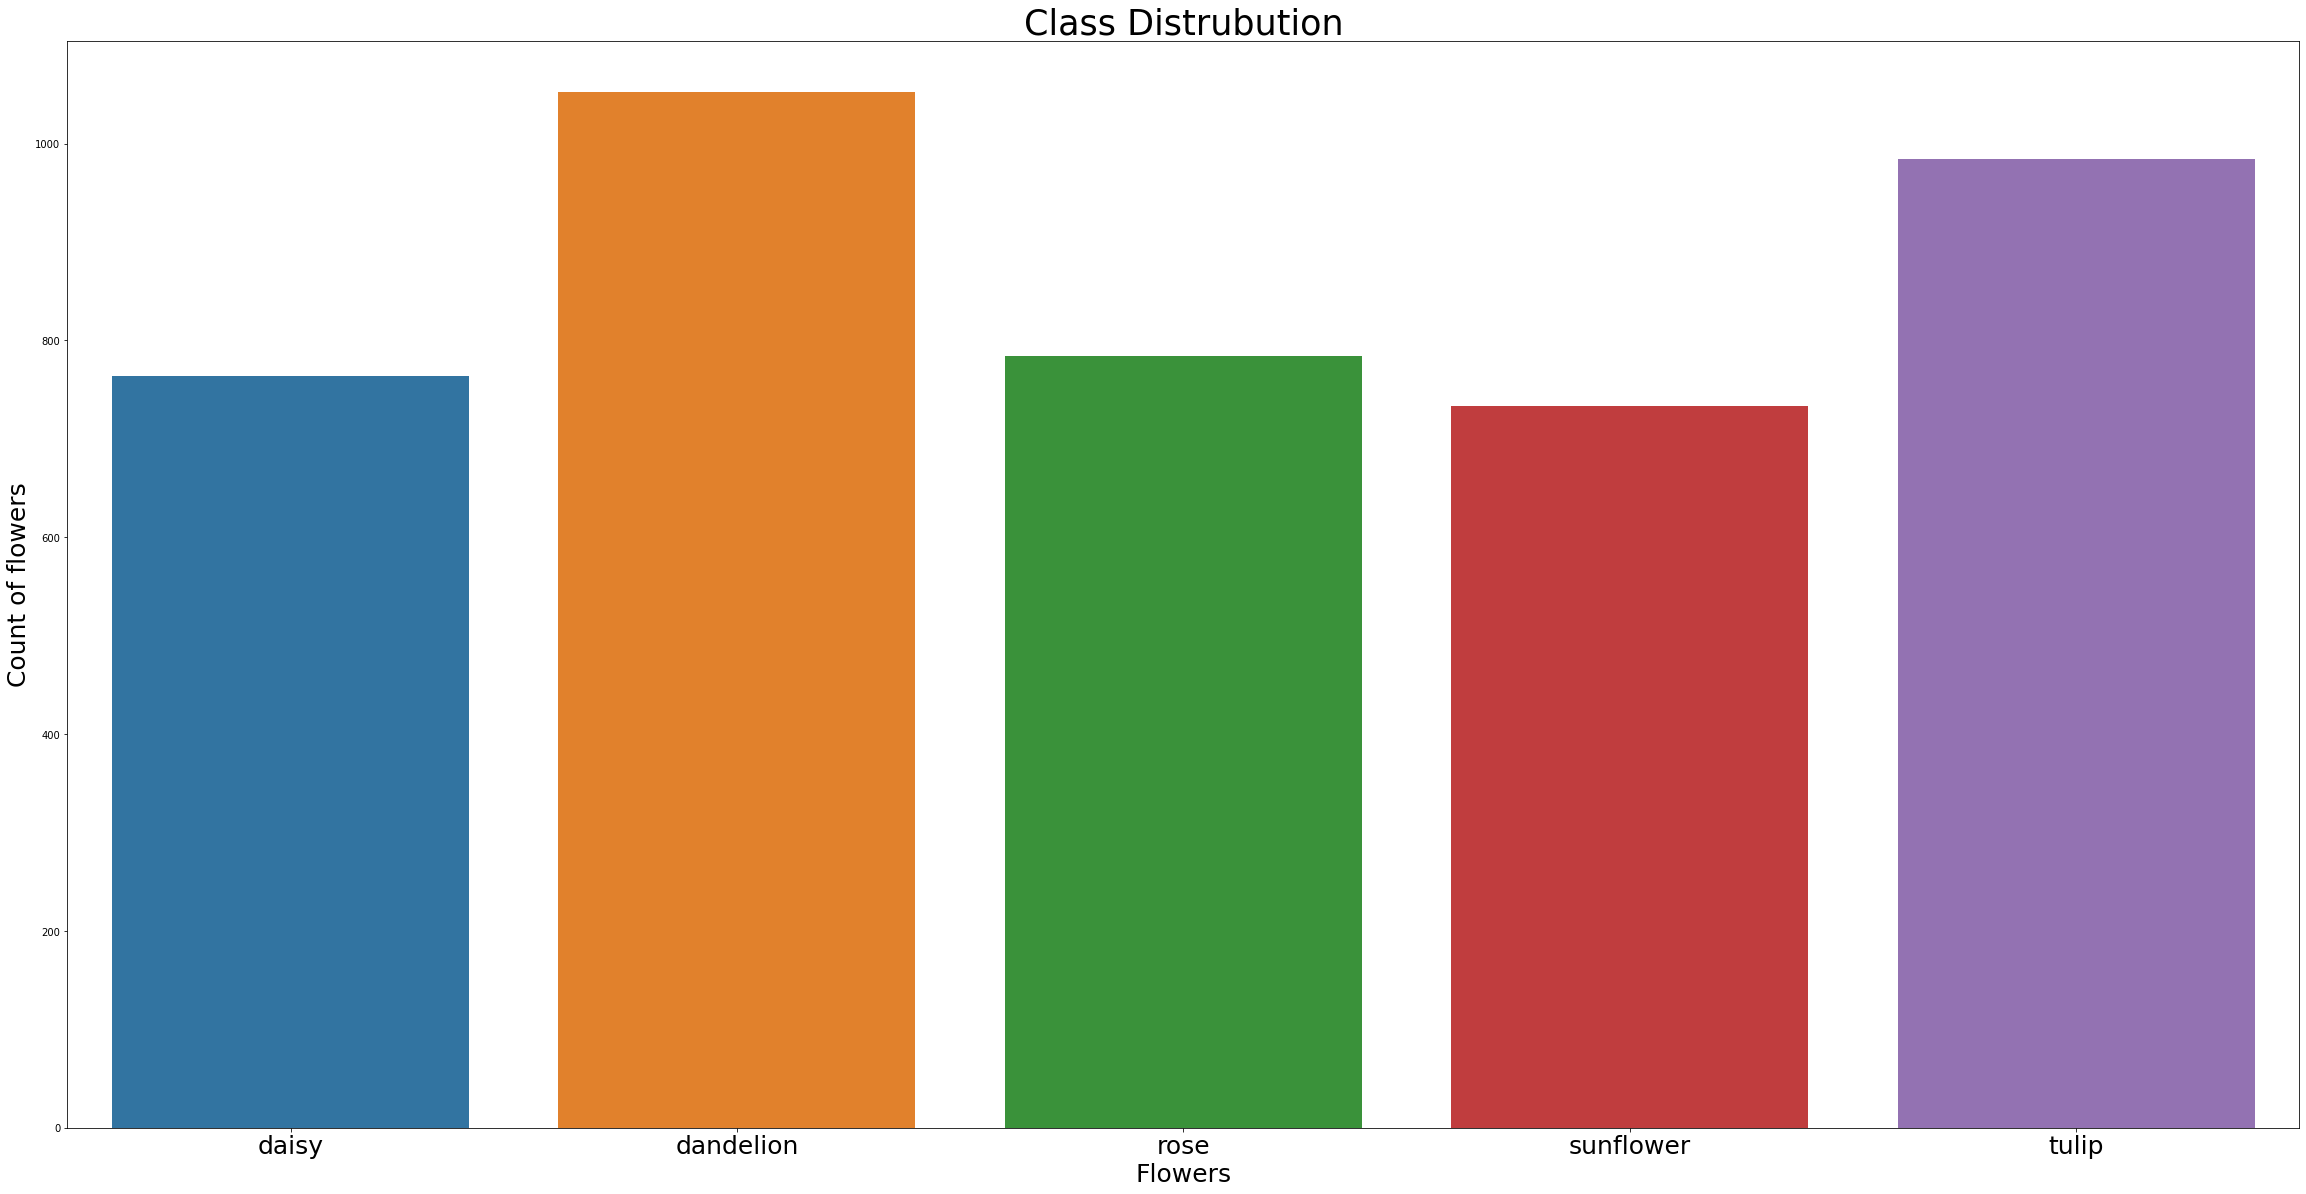

In [14]:
figure_size = plt.rcParams['figure.figsize']
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams['figure.figsize'] = figure_size

sns.barplot(data=samplesize)

index = np.arange(len(data.classes))

plt.xlabel('Flowers', fontsize=25)
plt.ylabel('Count of flowers', fontsize=25)
plt.xticks(index, data.classes, fontsize=25)
plt.title('Class Distrubution', fontsize=35)
plt.show()

**Let's see how the images from the original dataset look like without changes:**

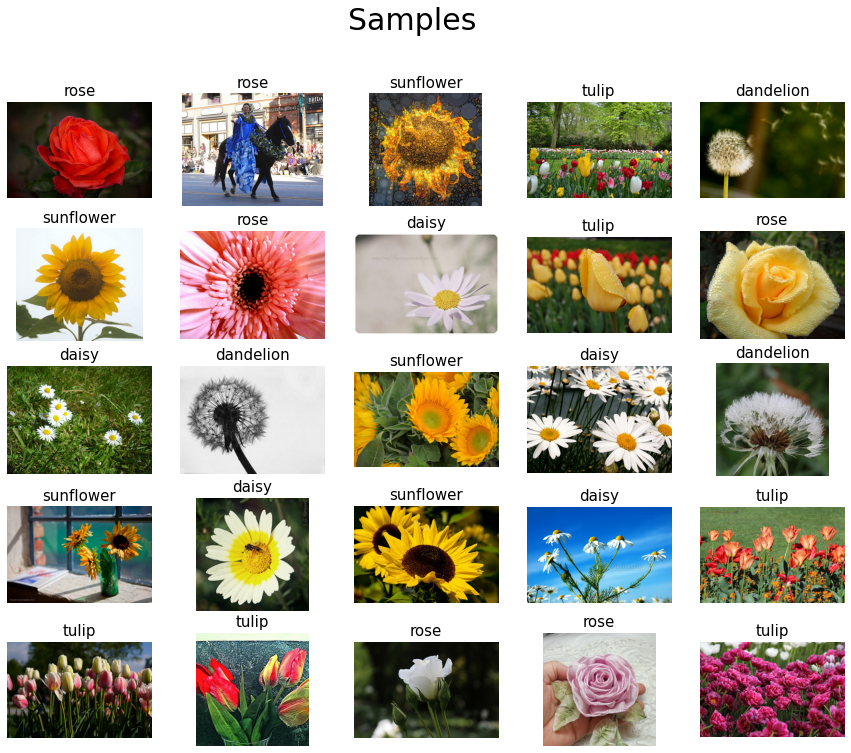

In [15]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = mpimg.imread(samples[i][0][0])
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1
  

rand_samples = [] 
for _ in range(25): 
    classes = random.choice(data.classes)
    rand_samples.append([random.sample([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)], 1), classes]) 
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Samples', fontsize=30)
plt.show()

**And this is how images with augmentation look like**

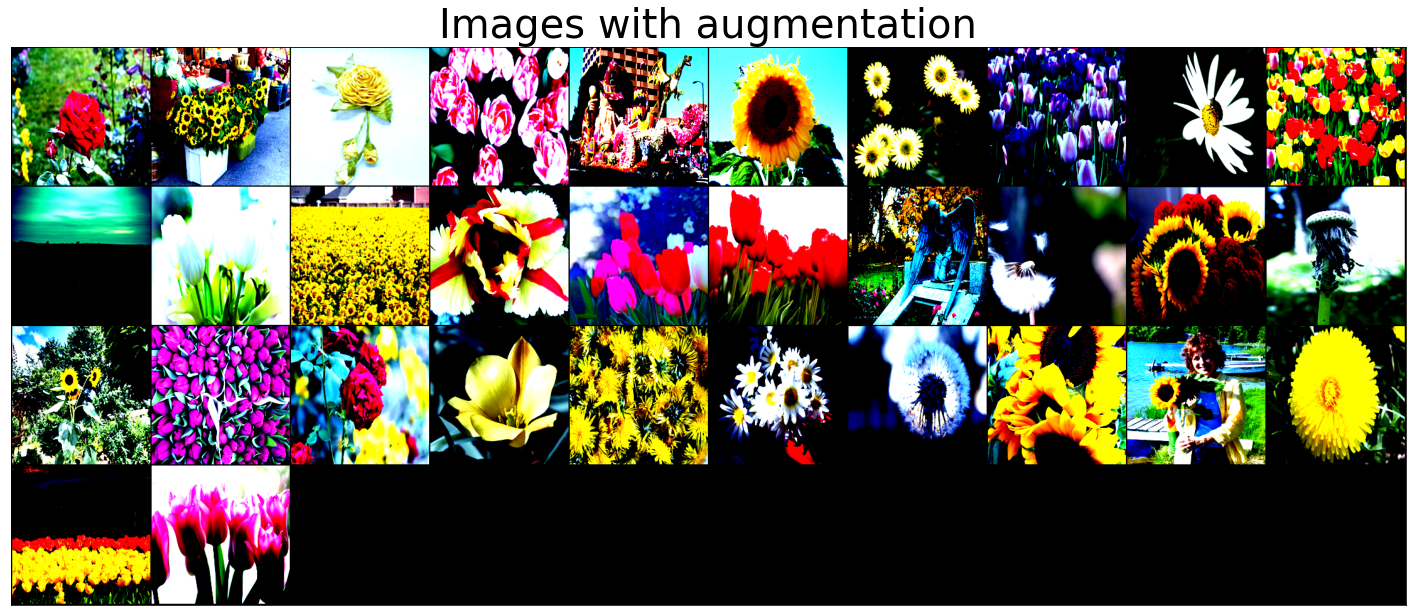

In [16]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        ax.set_title('Images with augmentation', fontsize=40)
        break
        
show_batch(loaders['train'])

# 3. Training and Test

**Idea:** I will use an ensemble of pre-trained models. I first train only the classifier on 10 epochs, then unfreeze the network and train all together for another 10 epochs

In order not to count the accuracy many times, we write the function

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

**This is where we will record the history of learning, so that we can make visualization later. We need visualization to evaluate learning, for example, overfitting or underfitting. Of course, we can analyze with numbers, but it is much easier to perceive information visually**

In [18]:
#save the losses for further visualization
losses = {'train':[], 'test':[]}
accuracies = {'train':[], 'test':[]}
lr = []

Train function structure:

1. **Classifier Training**
2. **Network-wide Training**

In [24]:
def train(seed, epochs, model):
    
  print('Creating a model {}...'.format(seed))

  model.to(device)  
  criterion = nn.CrossEntropyLoss()
  if seed==2 or seed==3:
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay = 1e-5)
  else:
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
  #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.1, epochs=epochs, steps_per_epoch=len(loaders['train']), cycle_momentum=True)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'test']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
#             lr.append(scheduler.get_lr())
#             scheduler.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

      if phase == 'train':
          acc = 100. * running_corrects.double() / dataset_sizes[phase]
          scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
      lr.append(scheduler._last_lr)
        
      if phase == 'test':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)
      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    #scheduler.step() 
  time_elapsed = time.time() - since
  print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)

# MODELS

**3. GoogleNet**

In [25]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
  param.grad_requires = False

googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=len(data.classes), bias=True)
#vgg19_bn.classifier[6] = nn.Linear(4096, len(original.classes), bias=True)

**Launching training**

In [26]:
epochs = 10
train(seed=2, epochs=epochs, model=googlenet)

Creating a model 2...
Epoch: 1/10
train - loss:0.9646191184602887, accuracy0.6852012742542716
test - loss:0.6181684644133957, accuracy0.8078703703703703
Time: 0.0m 12.89979100227356s
Epoch: 2/10
train - loss:0.5698739861772263, accuracy0.8230524181870836
test - loss:0.49219408410566823, accuracy0.829861111111111
Time: 0.0m 26.1026451587677s
Epoch: 3/10
train - loss:0.4771938869530589, accuracy0.8462206776715899
test - loss:0.4422986849590584, accuracy0.8414351851851851
Time: 0.0m 39.06021857261658s
Epoch: 4/10
train - loss:0.4317571934827196, accuracy0.854329568491167
test - loss:0.41781618915222307, accuracy0.8449074074074073
Time: 0.0m 51.994423151016235s
Epoch: 5/10
train - loss:0.40437828770348067, accuracy0.8656240949898638
test - loss:0.40293169683880276, accuracy0.8506944444444444
Time: 1.0m 5.171956539154053s
Epoch: 6/10
train - loss:0.38234116044246114, accuracy0.8714161598609904
test - loss:0.39263906081517536, accuracy0.8518518518518519
Time: 1.0m 18.180020809173584s
Epoch: 

In [27]:
losses

{'train': [0.974091834584216,
  0.5697663714496978,
  0.4804975411666154,
  0.42856157751246327,
  0.39894121206914934,
  0.37821065973897205,
  0.3618149229177281,
  0.344288291583847,
  0.33461729403236723,
  0.3291266702877208,
  0.9646191184602887,
  0.5698739861772263,
  0.4771938869530589,
  0.4317571934827196,
  0.40437828770348067,
  0.38234116044246114,
  0.35651675852319314,
  0.3426315951979129,
  0.33028058811715816,
  0.3231358660534434],
 'test': [0.6245071689287821,
  0.4940930395214646,
  0.44393260611428154,
  0.4162234134144253,
  0.4023572670088874,
  0.3907410232005296,
  0.38543083932664657,
  0.38215104628492286,
  0.3801978851358096,
  0.37141051171002565,
  0.6181684644133957,
  0.49219408410566823,
  0.4422986849590584,
  0.41781618915222307,
  0.40293169683880276,
  0.39263906081517536,
  0.3900198566692847,
  0.38275283409489524,
  0.37624976066527543,
  0.3771344801342046]}

In [35]:
torch.save(googlenet,'/kaggle/working/'+'googleNet_Classifier,pt')
# # Model class must be defined somewhere
model = torch.load('/kaggle/working/'+'googleNet_Classifier,pt')
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# 4. Loss and Accuracy Plots

**As you can see from the graphs, the unfreeze idea worked. We can see that after the red lines, the performance improves!**

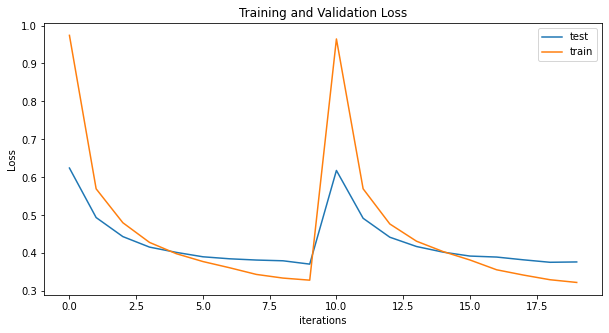

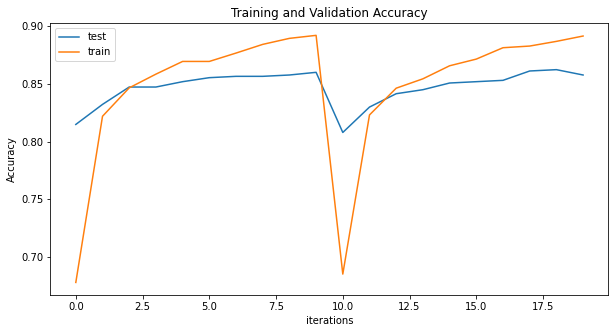

In [36]:
epoch_list = range(10)

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(losses['test'],label="test")
plt.plot(losses['train'],label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(accuracies['test'],label="test")
plt.plot(accuracies['train'],label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 5. Test set predictions

In [37]:
def validation_step(model,batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)                                      
        loss = F.cross_entropy(out, labels)                    
        acc,preds = accuracy(out, labels)                       
        
        return {'test_loss': loss.detach(), 'test_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
def test_prediction(outputs):
    batch_losses = [x['test_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()           
    batch_accs = [x['test_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()             
    # combine predictions
    batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
    # combine labels
    batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  

    return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
            'test_preds': batch_preds, 'test_labels': batch_labels}

**These functions will help us when calculating the accuracy**

In [38]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(model,batch) for batch in test_loader] 
    results = test_prediction(outputs)
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [41]:
model.to(device)
preds,labels = test_predict(model, loaders['test'])

test_loss: 0.3771, test_acc: 0.8576


# 7. Metrics

In [43]:
report = classification_report(labels, preds,
                               output_dict=True,
                               target_names=data.classes)
report_df = pd.DataFrame(report).transpose()

In [44]:
pd.set_option("display.max_rows", None)
report_df.head(134)

,precision,recall,f1-score,support
daisy,0.834483,0.883212,0.858156,137.000000
dandelion,0.935484,0.898230,0.916479,226.000000
rose,0.804196,0.804196,0.804196,143.000000
sunflower,0.901515,0.809524,0.853047,147.000000
tulip,0.806167,0.867299,0.835616,211.000000
accuracy,0.857639,0.857639,0.857639,0.857639
macro avg,0.856369,0.852492,0.853499,864.000000
weighted avg,0.860379,0.857639,0.858107,864.000000


<Figure size 2880x1440 with 0 Axes>

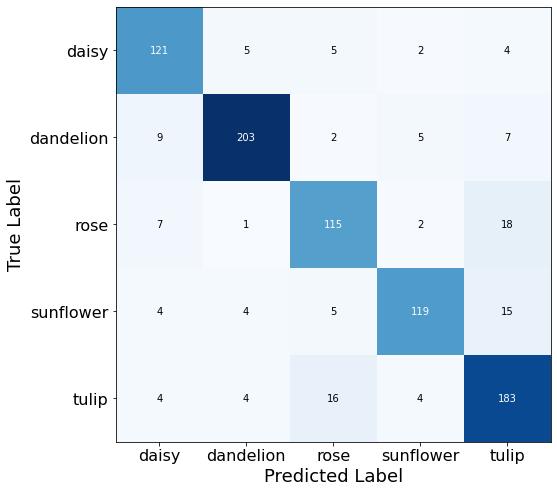

In [45]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(len(data.classes)), data.classes, fontsize=16)
plt.yticks(range(len(data.classes)), data.classes, fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()